In [1]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy


from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly
plotly.tools.set_credentials_file(username='********', api_key='*************')
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal

from functools import partial

from IPython.display import GeoJSON

For module 2 we'll be looking at techniques for dealing with big data. In particular binning strategies and the datashader library (which possibly proves we'll never need to bin large data for visualization ever again.)

To demonstrate these concepts we'll be looking at the PLUTO dataset put out by New York City's department of city planning. PLUTO contains data about every tax lot in New York City.

PLUTO data can be downloaded from [here](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page). Unzip them to the same directory as this notebook, and you should be able to read them in using this (or very similar) code. Also take note of the data dictionary, it'll come in handy for this assignment.

In [2]:
bk = pd.read_csv('BK_18v1.csv',low_memory=False)
bx = pd.read_csv('BX_18v1.csv',low_memory=False)
mn = pd.read_csv('MN_18v1.csv',low_memory=False)
qn = pd.read_csv('QN_18v1.csv',low_memory=False)
si = pd.read_csv('SI_18v1.csv',low_memory=False)

ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True,sort=False)

# Getting rid of some outliers
ny = ny[(ny['YearBuilt'] > 1850) & (ny['YearBuilt'] < 2020) & (ny['NumFloors'] != 0)]

I'll also do some prep for the geographic component of this data, which we'll be relying on for datashader.

You're not required to know how I'm retrieving the lattitude and longitude here, but for those interested: this dataset uses a flat x-y projection (assuming for a small enough area that the world is flat for easier calculations), and this needs to be projected back to traditional lattitude and longitude.

In [3]:


wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
ny['XCoord'] = 0.3048*ny['XCoord']
ny['YCoord'] = 0.3048*ny['YCoord']
ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['XCoord'].values, ny['YCoord'].values)

ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

## Part 1: Binning and Aggregation

Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and [2D histograms](https://plot.ly/python/2D-Histogram/) (also check out their close relatives: [2D density plots](https://plot.ly/python/2d-density-plots/) and the more general form: [heatmaps](https://plot.ly/python/heatmaps/).

While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

In [4]:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('YearBuilt').count()['BBL'].index,
    y = ny.groupby('YearBuilt').count()['BBL']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.Figure(data = [trace], layout = layout)

py.iplot(fig, filename = 'ny-year-built')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~njcooper137/0 or inside your plot.ly account where it is named 'ny-year-built'


Something looks off... You're going to have to deal with this imperfect data to answer this first question. 

But first: some notes on pandas. Pandas dataframes are a different beast than R dataframes, here are some tips to help you get up to speed:

---

Hello all, here are some pandas tips to help you guys through this homework:

[Indexing and Selecting](https://pandas.pydata.org/pandas-docs/stable/indexing.html): .loc and .iloc are the analogs for base R subsetting, or filter() in dplyr

[Group By](https://pandas.pydata.org/pandas-docs/stable/groupby.html):  This is the pandas analog to group_by() and the appended function the analog to summarize(). Try out a few examples of this, and display the results in Jupyter. Take note of what's happening to the indexes, you'll notice that they'll become hierarchical. I personally find this more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. Once you perform an aggregation, try running the resulting hierarchical datafrome through a [reset_index()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html).

[Reset_index](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html): I personally find the hierarchical indexes more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. reset_index() is a way of restoring a dataframe to a flatter index style. Grouping is where you'll notice it the most, but it's also useful when you filter data, and in a few other split-apply-combine workflows. With pandas indexes are more meaningful, so use this if you start getting unexpected results.

Indexes are more important in Pandas than in R. If you delve deeper into the using python for data science, you'll begin to see the benefits in many places (despite the personal gripes I highlighted above.) One place these indexes come in handy is with time series data. The pandas docs have a [huge section](http://pandas.pydata.org/pandas-docs/stable/timeseries.html) on datetime indexing. In particular, check out [resample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html), which provides time series specific aggregation.

[Merging, joining, and concatenation](https://pandas.pydata.org/pandas-docs/stable/merging.html): There's some overlap between these different types of merges, so use this as your guide. Concat is a single function that replaces cbind and rbind in R, and the results are driven by the indexes. Read through these examples to get a feel on how these are performed, but you will have to manage your indexes when you're using these functions. Merges are fairly similar to merges in R, similarly mapping to SQL joins.

Apply: This is explained in the "group by" section linked above. These are your analogs to the plyr library in R. Take note of the lambda syntax used here, these are anonymous functions in python. Rather than predefining a custom function, you can just define it inline using lambda.

Browse through the other sections for some other specifics, in particular reshaping and categorical data (pandas' answer to factors.) Pandas can take a while to get used to, but it is a pretty strong framework that makes more advanced functions easier once you get used to it. Rolling functions for example follow logically from the apply workflow (and led to the best google results ever when I first tried to find this out and googled "pandas rolling")

Google Wes Mckinney's book "Python for Data Analysis," which is a cookbook style intro to pandas. It's an O'Reilly book that should be pretty available out there.

---

### Question

After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

### Answer

My first step was to create a couple standard histograms to get a better feel for the data and to see what the distributions looked like individually. I binned both the building floor numbers and years in groups of ten, and also used semi-log plots per the instructions. We see that, for a city famed for it's vast number of sky-scrappers, the vast majority of buildings are less than 10 stories tall. This is obvious for anyone who has flown over NYC while flying into/out of LGA or Kennedy, and has taken a good look at the Buroughs.  However, on the ground those less numerous tall buildings dominate the sky-line.

In [5]:
# Start your answer here, inserting more cells as you go along
ny.head()
data = [go.Histogram(x=ny['NumFloors'], nbinsx = 20)]
layout = go.Layout(
    xaxis=dict(
        type='linear',
        autorange=True,
        title = 'Number of Floors by Sets of 10'
    ),
    yaxis=dict(
        type='log',
        autorange=True,
        title = 'Number of Buildings'
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='floor_built_histogram')

C:\Users\Nate\Anaconda3\lib\site-packages\plotly\plotly\plotly.py:233: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



In the year the buidlings were built, we use data going back to 1850. We also see that in the 1890s there was a bulding boom that peeked in the 1930s, and has never abated even to this day. That said it is interesting to note that the peek of the building boom was the 'Roaring Twenties'. Likely due to the unprecendented ecomonic growth the US underwent after WW1. The Great Depression only saw a small decrease, more than likely due to New Deal public works projects. The number of buildings produced per decade did not drop below 1890s numbers until the 2000s. This is the decade of the Great Recession which was brought about by the housing bubble bursting.

In [6]:
data = [go.Histogram(x=ny['YearBuilt'], nbinsx =32)]
layout = go.Layout(
    xaxis=dict(
        type='linear',
        autorange=True,
        title = 'Decade Built'
    ),
    yaxis=dict(
        type='log',
        autorange=True,
        title = 'Number of Buildings'
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='year_built_histogram')

C:\Users\Nate\Anaconda3\lib\site-packages\plotly\plotly\plotly.py:233: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



Finally, I combined both data sets into a 2D Histogram. The challenge, as stated in the question is that the count data is logrithmic in nature. In the graph below that logritmic nature is represented in the color scale. The blues represent the proportion of buildings on the order of 1 part per quater million. The yellows are on the order of 1 part per 10 thousand. Orange hues are on the order of percent and reds are one part per 10. Getting the color scale to the right of the graph to refect the logrithmic nature of the color scale was challenging. I set the ticks at the color bar to 0.000025, 0.01, 0.1 and 0.2 to at at least give the feel of the logrithmic nature of the data. Unforunately the blue and green hues are a barely visable strip at the bottom. 

In [7]:
data = [
    go.Histogram2d(x=ny['YearBuilt'], y=ny['NumFloors'], histnorm='probability',
        autobinx=False,
        xbins=dict(start=1850, end=2019, size=1),
        autobiny=False,
        ybins=dict(start=1, end=120, size=1),
        colorscale=[[0, 'rgb(255,255,255)'], [0.000025, 'rgb(10,136,186)'], [0.0001, 'rgb(242,211,56)'], [0.01, 'rgb(242,143,56)'], [1, 'rgb(217,30,30)']],
        colorbar = dict(tick0= 0, tickmode= 'array', tickvals= [0.000025, 0.01,0.04,0.08])           
    )
]
layout = go.Layout(
    xaxis=dict(
        title = 'Year Built'
    ),
    yaxis=dict(
        title = 'Number of Floors'
    )
)
fig = go.Figure(data=data,  layout=layout)
py.iplot(fig, filename='year_floors_2dhistogram')

C:\Users\Nate\Anaconda3\lib\site-packages\plotly\plotly\plotly.py:233: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



In peer-reviewed science, the color scale would be explained in the caption of the figure and would not represent much of an inpediment to the graph being published. In data science that would be a data scientist to data scientist interaction. When we communicate with professionals of other fields the results being obvious without reading a caption may be more important.

Even with the akward colorbar, we can see that tall buildings are rare. The majority of buildings in NYC are less than 10 stories, and over a third (approximately 39.3%) were built between WW1 and WW2. We can also see that the tall buildings > 20 stories, built prior to 1920, which are shaded in light blue to yellow represent about 1 and 10,000 buildings total. Fortunately, these buildings are every rare. 

## Part 2: Datashader

Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.

As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [8]:
yearbins = 200
floorbins = 200

yearBuiltCut = pd.cut(ny['YearBuilt'], np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['NumFloors'], np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))

xlabels = np.floor(np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))

data = [
    go.Heatmap(z = ny.groupby([numFloorsCut, yearBuiltCut])['BBL'].count().unstack().fillna(0).values,
              colorscale = 'Greens', x = xlabels, y = ylabels)
]

py.iplot(data, filename = 'datashader-2d-hist')

This shows us the distribution, but it's subject to some biases discussed in the Anaconda notebook [Plotting Perils](https://anaconda.org/jbednar/plotting_pitfalls/notebook). 

Here is what the same plot would look like in datashader:



C:\Users\Nate\Anaconda3\lib\site-packages\datashader\transfer_functions.py:162: RuntimeWarning:

invalid value encountered in log1p



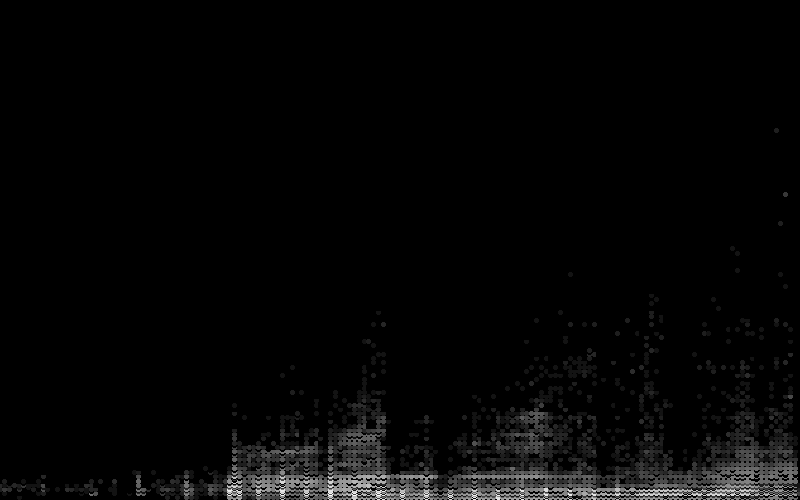

In [9]:
cvs = ds.Canvas(800, 500, x_range = (ny['YearBuilt'].min(), ny['YearBuilt'].max()), 
                                y_range = (ny['NumFloors'].min(), ny['NumFloors'].max()))
agg = cvs.points(ny, 'YearBuilt', 'NumFloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

That's technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions.

Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:

C:\Users\Nate\Anaconda3\lib\site-packages\datashader\transfer_functions.py:162: RuntimeWarning:

invalid value encountered in log1p



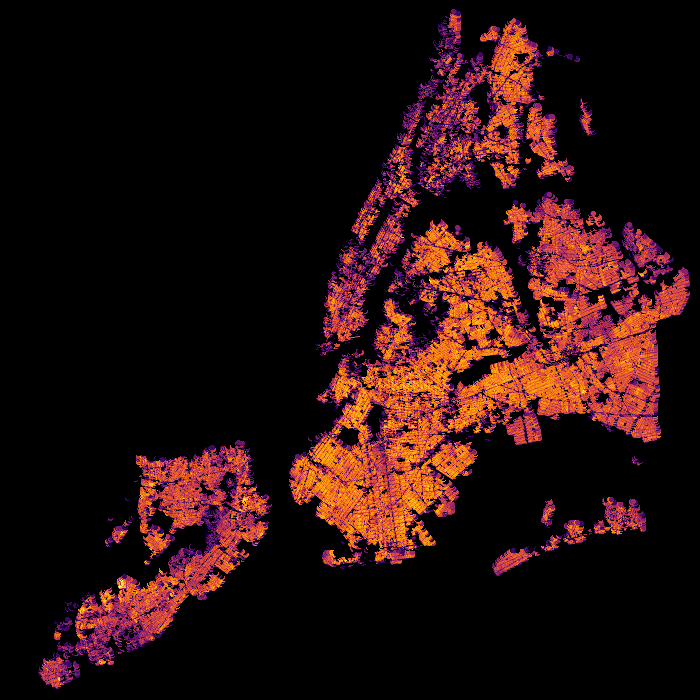

In [10]:
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes.

Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their [github repo](https://github.com/bokeh/datashader/tree/master/examples). I would focus on the [visualization pipeline](https://anaconda.org/jbednar/pipeline/notebook) and the [US Census](https://anaconda.org/jbednar/census/notebook) Example for the question below. [This talk](https://www.youtube.com/watch?v=6m3CFbKmK_c) also provides a nice background for datashader. Feel free to use my samples as templates as well when you work on this problem.

### Question

You work for a real estate developer and are researching underbuilt areas of the city. After looking in the [Pluto data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=17v1_1), you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about [bivariate choropleth maps](http://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/), and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

### Answer

My first step was to do some exploritory statistics to get a feel for what the data looked like. Interestingly, there are one 
data point in the tax land assement that was negative (something like -0.000000000001) probably a rounding error from the source
database. To make log transforms without causing a inf, I added 1 dollar to each assement. This would allow the log tranformation, but was small enough to be insignificant for most tax assessments.

In [11]:
ny['AssessLand'] = ny['AssessLand'] + 1
ny['AssessTot'] = ny['AssessTot'] + 1
print(ny['AssessLand'].describe())
ny['AssessRatio'] = ny['AssessTot']/ny['AssessLand']
print(ny['AssessRatio'].describe())
ny['AssessBuild'] = ny['AssessTot']-ny['AssessLand']
ny['AssessBuild'] = ny['AssessBuild'] + 1
print(ny['AssessBuild'].describe())
ny['LogAL'] = np.log10(ny['AssessLand'])
print(ny['LogAL'].describe())
ny['LogBL'] = np.log10(ny['AssessBuild'])
print(ny['LogBL'].describe())
#NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
#cvs = ds.Canvas(700, 700, *NewYorkCity)
#agg = cvs.points(ny, 'lon', 'lat', ny['AssessRatio'])
#view = tf.shade(agg, cmap = cm(inferno), how='log')
#export(tf.spread(view, px=2), 'firery')

count    8.111340e+05
mean     9.481744e+04
std      3.854979e+06
min      1.000000e+00
25%      6.987000e+03
50%      9.657000e+03
75%      1.428900e+04
max      3.211276e+09
Name: AssessLand, dtype: float64
count    811134.000000
mean          5.418300
std          10.715830
min           1.000000
25%           2.608910
50%           3.330717
75%           4.450928
max        1268.153846
Name: AssessRatio, dtype: float64
count    8.111340e+05
mean     3.529786e+05
std      6.470891e+06
min      1.000000e+00
25%      1.552300e+04
50%      2.188350e+04
75%      3.391975e+04
max      3.746639e+09
Name: AssessBuild, dtype: float64
count    811134.000000
mean          4.097185
std           0.522755
min           0.000000
25%           3.844291
50%           3.984842
75%           4.155002
max           9.506678
Name: LogAL, dtype: float64
count    811134.000000
mean          4.501116
std           0.585787
min           0.000000
25%           4.190976
50%           4.340117
75%          

I started by making a few histograms with plotly, but it crashed because I ran out of inport/exports due to having a free account

In [12]:
data = [go.Histogram(x=ny['LogAL'], nbinsx =100)]
layout = go.Layout(
    xaxis=dict(
        type='linear',
        autorange=True,
        title = 'Log(Land Tax Assessment), USD'
    ),
    yaxis=dict(
        type='log',
        autorange=True,
        title = 'Number of Buildings'
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='land_assess_histogram')

C:\Users\Nate\Anaconda3\lib\site-packages\plotly\plotly\plotly.py:233: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



In [13]:
data = [go.Histogram(x=ny['LogBL'], nbinsx =100)]
layout = go.Layout(
    xaxis=dict(
        type='linear',
        autorange=True,
        title = 'Building Tax Assessment, USD'
    ),
    yaxis=dict(
        type='log',
        autorange=True,
        title = 'Number of Buildings'
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='build_assess_histogram')

C:\Users\Nate\Anaconda3\lib\site-packages\plotly\plotly\plotly.py:233: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



In [14]:

data = [
    go.Histogram2d(x=ny['LogAL'], y=ny['LogBL'], histnorm='probability',
        autobinx=False,
        xbins=dict(start=0, end=10, size=0.1),
        autobiny=False,
        ybins=dict(start=0, end=10, size=0.1),
        colorscale=[[0, 'rgb(255,255,255)'], [0.000025, 'rgb(10,136,186)'], [0.0001, 'rgb(242,211,56)'], [0.01, 'rgb(242,143,56)'], [1, 'rgb(217,30,30)']],
        colorbar = dict(tick0= 0, tickmode= 'array', tickvals= [0.000025, 0.01,0.02,0.04])         
    )
]
layout = go.Layout(
    xaxis=dict(
        title = 'Log base 10 Assessed Land Value USD'
    ),
    yaxis=dict(
        title = 'Log base 10 Assessed Building Value USD'
    )
)
fig = go.Figure(data=data,  layout=layout)
py.iplot(fig, filename='land_build_2dhistogram')


C:\Users\Nate\Anaconda3\lib\site-packages\plotly\plotly\plotly.py:233: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



As per your instructions, I used your code as a basis for making the datashader plots I started with a 2D histogram, like the one above, to get a feel for the relationship between the Assessed Land Value and Assessed Building Value. We see a mostly linear relationship centered at tens of thousands to hundreds of thousands of dollars. The upper cluster represent buildings that assessed higher than the land they were on, that is, over developed plots.

C:\Users\Nate\Anaconda3\lib\site-packages\datashader\transfer_functions.py:162: RuntimeWarning:

invalid value encountered in log1p



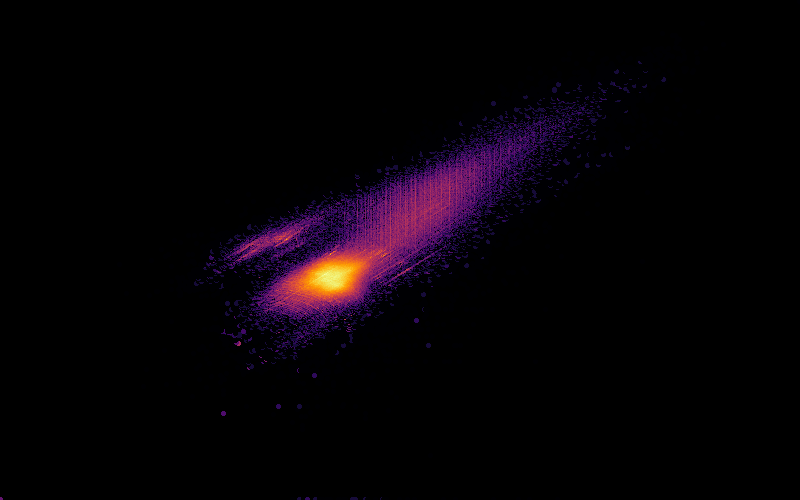

In [15]:
#ny['AssessBuild'].isna().sum()

cvs = ds.Canvas(800, 500, x_range = (ny['LogAL'].min(), ny['LogAL'].max()), 
                                y_range = (ny['LogBL'].min(), ny['LogBL'].max()))
agg = cvs.points(ny, 'LogAL', 'LogBL')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'Land_v_Build_assess')

Now I did seperate plots of the assessed land and building values, overlaid on the grid coordinates you provided. 
The above youtube video (https://www.youtube.com/watch?v=6m3CFbKmK_c) helped fill in the needed arguments for cvs.points().

Aside from using different color maps, the charts are quite similar to each other. No stark contrasts stick out between the individual maps.

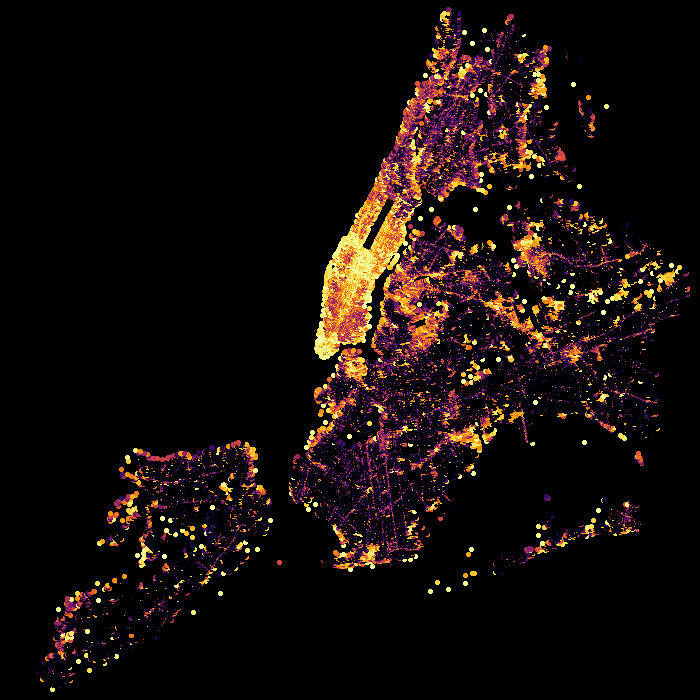

In [16]:
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat', ds.mean('AssessLand'))
view = tf.shade(agg, cmap = cm(inferno), how='eq_hist')
export(tf.spread(view, px=2), 'Assessment')

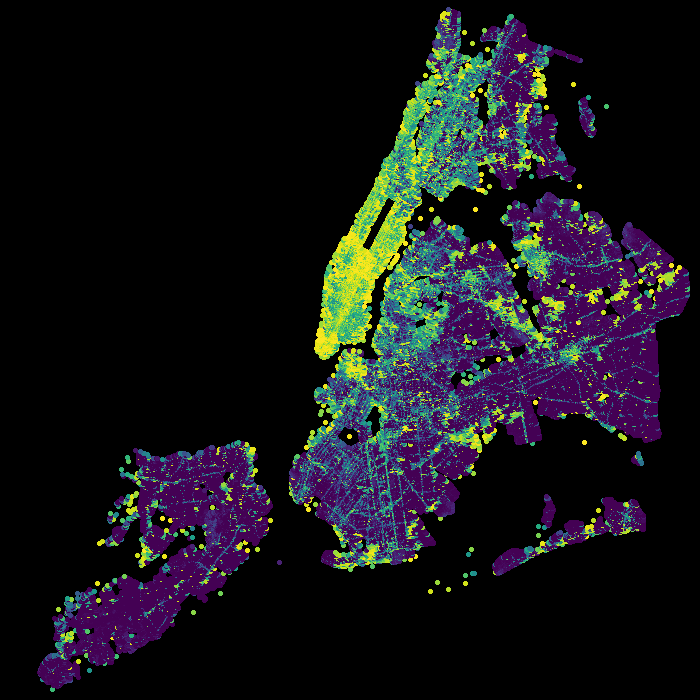

In [17]:
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat', ds.mean('AssessBuild'))
view = tf.shade(agg, cmap = cm(viridis), how='eq_hist')
export(tf.spread(view, px=2), 'Assessment')

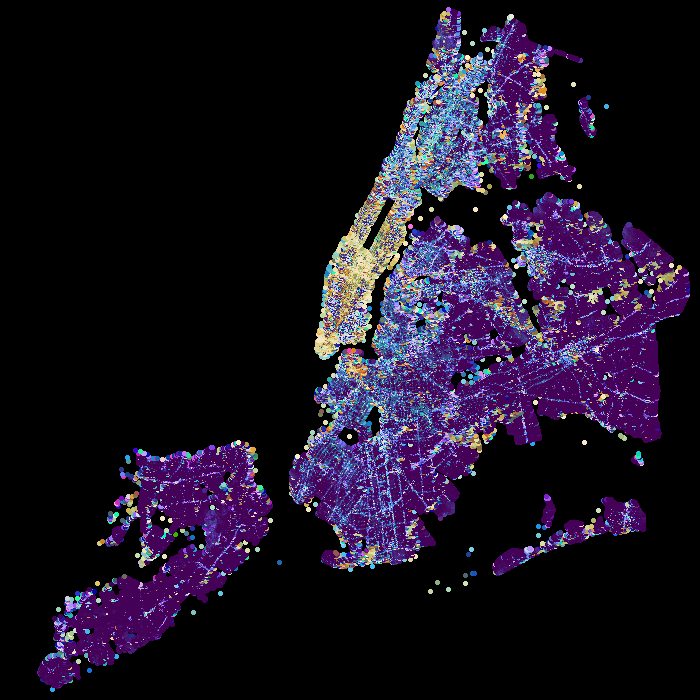

In [18]:
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
AL = cvs.points(ny, 'lon', 'lat', ds.mean('AssessLand'))
BL = cvs.points(ny, 'lon', 'lat', ds.mean('AssessBuild'))
view1 = tf.shade(AL, cmap =  cm(inferno), how='eq_hist')
view2 = tf.shade(BL, cmap =  cm(viridis), how='eq_hist')
img = tf.stack(view2,view1, how='add') #The how = add required me looking up the source code for datashader
export(tf.spread(img, px=2), 'Bivariate_Choropleth_Map')

The Bivariate Choropleth Map above is a mix of the inferno and viridis color pallets. The dark areas are areas of lower land
and lower building values. These are most in the outer boroughs which are dominated by small residential buildings. The yellow area are both high value in land and buildings. These areas are midtown Manhattan and downtown Manhattan, which are dominated by high rise commericial buildings. You also see areas like this in Flushing Queens and Downtown Brooklyn which are also large commericial area. Blue, where building values are more than land values tend to be water front properties, expensive residential areas, and light commerical properties along major avenues most of the major thoroughfares in Queens and Brooklyn stand out for this reason. Pink colors, where land value is greater than building value is very rare and parodoxically is mostly along the water front. You also get these hues in some of the poorer neighborhoods such as the South Bronx.